 # PVRP（期間配車計画問題）

## 定式化

$$
minimize \quad \sum_{ij}^{}c_{ij}x_{ijt} \quad　(i<j)
$$

$$
 subject \quad to \quad \sum_{j}^{}x_{1jt} <= 2m   \quad(\forall{t}\in{T})
$$

$$
 \sum_{i}^{}x_{ijt}+\sum_{j}^{}x_{jit} = 2\sum_{p}a_{ipt}y_{ip} \quad (\forall{i,t}\in{N,T})
$$

$$
\sum_{i}^{}y_{ip}\quad = 1 \quad (\forall{i,p}\in{N,P})
$$

$$
\sum_{t} \sum_{i,j \in S}x_{ij} <= |S| - N(S)
$$

$$
x_{1jt} \in {0,1,2}
$$

$$
x_{ijt} \in {0,1}
$$

$$
y_{ip} \in {0,1} 
$$

### 制約説明
制約１：m台の運搬車があり、点１に出入りする運搬車を表す枝の本数が2m以下である.

制約２：各顧客に対して各訪問パターンから一つを選んで運搬車が１台訪問する.

制約３：各顧客に対して、訪問パターンから一つを選ぶ.

制約４：運搬車の容量制約と部分巡回路を禁止するもの.
N(S)はS内の顧客の需要を運ぶための運搬車の数

### 線形計画緩和で解く場合
$$
y_{ip} \in [{0,1}]
$$

ではなく

$$
y_{ip}  \quad [0<=y<=1]
$$


In [22]:
from gurobipy import Model,quicksum,GRB
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import sys

 ## dataset

In [23]:
import random
random.seed(1)
V = [i for i in range(10)] #デポと顧客の集合
q = {} #顧客の需要
for i in V:
    q[0] = 0
    q[i] = random.randint(10,20)
np.random.seed(0)
#配列作成
x_y = np.random.rand(len(V), 2) * 100
Q = 100 #車両の最大積載量
m = 1 #車両数
day = 2
T = [0,1]#日にちの集合
a = [2 for i in range(len(V))]
li = [(1,2) for i in range(len(V))]
pat = [()]
for i in li:
    pat.append(((format(i[1],'b').zfill(a[0]))
              ,(format(i[0],'b').zfill(a[0]))))
q

{0: 0, 1: 19, 2: 11, 3: 14, 4: 11, 5: 17, 6: 17, 7: 17, 8: 20, 9: 16}

In [24]:
pat = []
for i in range(1,len(li)):
    ll = []
    for j in range(len(li[i])):
        ll.append((format(li[i][j],'b').zfill(day)))
    pat.append(ll)
a = [()]
P = [()]
for i1 in pat:
    ml = []
    for i2 in i1[::-1]:
        ll = []
        for i3 in i2:
            ll.append(int(i3))
        ml.append(ll)
    patdata = np.array(ml)
    n_pat = [i for i in range(len(patdata))]
    #print(patdata)
    a.append(patdata)
    P.append(n_pat)
print(a)

[(), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]])]


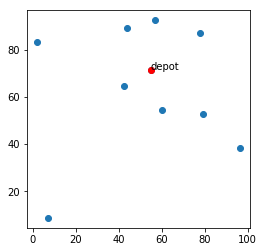

In [25]:
plt.figure(figsize=(4, 4))
plt.plot(x_y[:, 0], x_y[:, 1], 'o')
plt.plot(x_y[0][0],x_y[0][1],"ro")#デポを描画
plt.text(x_y[0][0],x_y[0][1], "depot")
plt.show()

In [26]:
x_y = np.array(x_y)
x = x_y[:, 0]
y = x_y[:, 1]
di = np.sqrt((x[:, np.newaxis] - x[np.newaxis, :]) ** 2 +(y[:, np.newaxis] - y[np.newaxis, :]) ** 2)
Route = {(i,j) for i in V for j in V}

In [27]:
#Parameter
c = {} #移動間のコスト
for i in range(len(x_y)):
    for j in range(len(x_y)):
        c[i,j] = di[i,j]

 # Gurobiで解く

In [28]:
import math
import random
import networkx
from gurobipy import *

In [29]:
def vrp_callback(model,where):
    if where != GRB.callback.MIPSOL:#新しい解を発見した時だけ部分巡回路除去制約を追加
        return
    for t in T:
        edges = []
        for (i,j,t2) in x:
            if model.cbGetSolution(x[i,j,t]) > .5:
                if t == t2 and i != V[0] and j != V[0]:
                    edges.append( (i,j) )
        G = networkx.Graph()
        G.add_edges_from(edges)
        Components = networkx.connected_components(G)
        for S in Components:
            S_card = len(S)
            q_sum = sum(q[i] for i in S)
            NS = int(math.ceil(float(q_sum)/Q))
            S_edges = [(i,j) 
                       for i in S 
                       for j in S
                       if i<j and (i,j) in edges]
            if S_card >= 3 and (len(S_edges) >= S_card or NS > 1):
                model.cbLazy(quicksum(x[i,j,t]
                                      for i in S 
                                      for j in S 
                                      for t in T 
                                      if j > i) <= S_card-NS)
                #print ("adding cut for" , S_edges)
    return

In [30]:
model = Model("pvrp")

In [31]:
#変数
x = {}
for i in V:
    for j in V:
        for t in T:
            if j > i and i == V[0]:       # depot
                x[i,j,t] = model.addVar(ub=2, vtype="I", name="x(%s,%s,%s)"%(i,j,t))
            elif j > i:
                x[i,j,t] = model.addVar(ub=1, vtype="I", name="x(%s,%s,%s)"%(i,j,t))


model.update()
#for (i,j,t) in x:
#    print(x[i,j,t])

In [32]:
y = {}
for i in V:
    for p in P[i]:
        #y[i,p] = model.addVar(vtype="B",name = f"y[{i},{p}]")
        y[i,p] = model.addVar(lb=0, ub=1.0, vtype="S", name = f"y[{i},{p}]")
model.update()
for (i,p) in y:
    print(y[i,p])

<gurobi.Var y[1,0]>
<gurobi.Var y[1,1]>
<gurobi.Var y[2,0]>
<gurobi.Var y[2,1]>
<gurobi.Var y[3,0]>
<gurobi.Var y[3,1]>
<gurobi.Var y[4,0]>
<gurobi.Var y[4,1]>
<gurobi.Var y[5,0]>
<gurobi.Var y[5,1]>
<gurobi.Var y[6,0]>
<gurobi.Var y[6,1]>
<gurobi.Var y[7,0]>
<gurobi.Var y[7,1]>
<gurobi.Var y[8,0]>
<gurobi.Var y[8,1]>
<gurobi.Var y[9,0]>
<gurobi.Var y[9,1]>


In [33]:
#制約
    
#トラックがデポから出発する制約
for t in T:
    model.addConstr(quicksum(x[V[0],j,t] for j in V[1:]) <= 2*m )

#必ず一台の車両により顧客へのサービスが行われる割り当て制約
for i in V[1:]:
    for t in T:
        model.addConstr(quicksum(x[j,i,t] for j in V if j < i) +
                        quicksum(x[i,j,t] for j in V if j > i) == 
                        2 * quicksum(a[i][p][t]* y[i,p]for p in P[i]))

#必ず全ての顧客を回る制約
for i in V[1:]:
    model.addConstr(quicksum(y[i,p] for p in P[i]) == 1)

model.update()

In [34]:
#目的関数
model.setObjective(quicksum(c[i,j]*x[i,j,t] 
                            for i in V
                            for j in V 
                            for t in T
                            if j>i), GRB.MINIMIZE)

model.update()
#model.__data = x
model.write("sp.lp")

In [35]:
model.params.DualReductions = 0
model.params.LazyConstraints = 1
model.optimize(vrp_callback)
#model.optimize()
#x = model.__data

for t in T:
    edges = []
    for (i,j,t2) in x:
        if x[i,j,t].X > .5:
            if t2 == t and i != V[0] and j != V[0]:
                    edges.append( (i,j) )

print ("Optimal solution:",model.ObjVal)
print ("Edges in the solution:")
print (sorted(edges))

Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Optimize a model with 29 rows, 108 columns and 216 nonzeros
Variable types: 0 continuous, 90 integer (0 binary)
Semi-Variable types: 18 continuous, 0 integer
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 2e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 18 rows and 18 columns
Presolve time: 0.00s
Presolved: 11 rows, 90 columns, 180 nonzeros
Variable types: 0 continuous, 90 integer (72 binary)
Found heuristic solution: objective 383.3781578

Root relaxation: objective 3.118293e+02, 15 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     311.8293482  311.82935  0.00%     -    0s

Cutt

In [36]:
#変数の確認
for v in model.getVars():
    if v.X> 0:
        print(v.VarName, v.X)

x(1,2,1) 1.0
x(1,9,1) 1.0
x(2,3,0) 1.0
x(3,6,1) 1.0
x(4,5,0) 1.0
x(4,5,1) 1.0
x(6,9,0) 1.0
x(7,8,0) 1.0
x(7,8,1) 1.0
y[1,1] 1.0
y[2,0] 0.5
y[2,1] 0.5
y[3,0] 0.5
y[3,1] 0.5
y[4,0] 0.5
y[4,1] 0.5
y[5,0] 0.5
y[5,1] 0.5
y[6,0] 0.5
y[6,1] 0.5
y[7,0] 0.5
y[7,1] 0.5
y[8,0] 0.5
y[8,1] 0.5
y[9,0] 0.5
y[9,1] 0.5


In [37]:
print ("Optimal solution:",model.ObjVal)

Optimal solution: 311.8293482476421


In [38]:
opt = model.ObjVal
print(f"最適距離: {opt}")

最適距離: 311.8293482476421


In [39]:
model.status

2

In [40]:
#変数の確認
#for v in model.getVars():
#    if v.X> 0:
#        print(v.VarName, v.X)

 # ルートの可視化

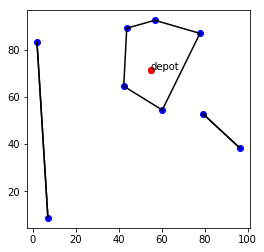

In [41]:
plt.figure(figsize=(4, 4))
plt.scatter(x_y[:, 0], x_y[:, 1], c='b')
#plt.text(x_y[:,0]+1,x_y[:,1]+1, str(V[0:]))
plt.scatter(x_y[0][0],x_y[0][1],c="r")#デポを描画
plt.text(x_y[0][0],x_y[0][1], "depot")

for t in T:
    for i in V:
        for j in V:
            if i < j and x[i,j,t].x >= 0.9:
                plt.plot([x_y[i][0],x_y[j][0]], [x_y[i][1], x_y[j][1]], c="black")
plt.show()

In [42]:
s = 'abcabcabc'
target = 'b'
index = -1
while True:
    index = s.find(target, index + 1)
    print(index)
    print(bool(index == -1))
    if index == -1:
        break
    print('start=%d' % index)

1
False
start=1
4
False
start=4
7
False
start=7
-1
True


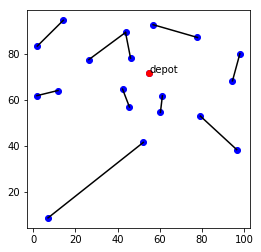

In [153]:
#１日目
plt.figure(figsize=(4, 4))
plt.scatter(x_y[:, 0], x_y[:, 1], c='b')
#plt.text(x_y[:,0]+1,x_y[:,1]+1, str(V[0:]))
plt.scatter(x_y[0][0],x_y[0][1],c="r")#デポを描画
plt.text(x_y[0][0],x_y[0][1], "depot")

for t in T:
    if t == 0:
        for i in V:
            for j in V:
                if i < j and x[i,j,t].x >= 0.9:
                    plt.plot([x_y[i][0],x_y[j][0]], [x_y[i][1], x_y[j][1]], c="black")
plt.show()

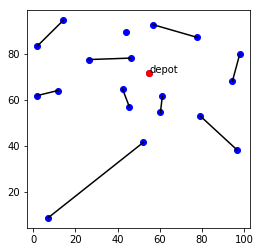

In [154]:
#2日目
plt.figure(figsize=(4, 4))
plt.scatter(x_y[:, 0], x_y[:, 1], c='b')
#plt.text(x_y[:,0]+1,x_y[:,1]+1, str(V[0:]))
plt.scatter(x_y[0][0],x_y[0][1],c="r")#デポを描画
plt.text(x_y[0][0],x_y[0][1], "depot")

for t in T:
    if t == 1:
        for i in V:
            for j in V:
                if i < j and x[i,j,t].x >= 0.9:
                    plt.plot([x_y[i][0],x_y[j][0]], [x_y[i][1], x_y[j][1]], c="black")
plt.show()

In [56]:
import math
import random
import networkx
from gurobipy import *

def vrp(V,c,m,q,Q,T,P):
    
    def vrp_callback(model,where):
        if where != GRB.callback.MIPSOL:#新しい解を発見した時だけ部分巡回路除去制約を追加
            return
        for t in T:
            edges = []
            for (i,j,t2) in x:
                if model.cbGetSolution(x[i,j,t]) > .5:
                    if t == t2 and i != V[0] and j != V[0]:
                        edges.append( (i,j) )
            #print("#############")
            G = networkx.Graph()
            G.add_edges_from(edges)
            Components = networkx.connected_components(G)
            for S in Components:
                S_card = len(S)
                q_sum = sum(q[i] for i in S)
                NS = int(math.ceil(float(q_sum)/Q))
                S_edges = [(i,j) 
                           for i in S 
                           for j in S
                           if i<j and (i,j) in edges]
                if S_card >= 3 and (len(S_edges) >= S_card or NS > 1):
                    model.cbLazy(quicksum(x[i,j,t]
                                          for i in S 
                                          for j in S 
                                          for t in T 
                                          if j > i) <= S_card-NS)
                    #print ("adding cut for" , S_edges)
        return


    model = Model("vrp")
    
    #変数
    
    x = {}
    for i in V:
        for j in V:
            for t in T:
                if j > i and i == V[0]:       # depot
                        x[i,j,t] = model.addVar(ub=2, vtype="I", name="x(%s,%s,%s)"%(i,j,t))
                elif j > i:
                    x[i,j,t] = model.addVar(ub=1, vtype="I", name="x(%s,%s,%s)"%(i,j,t))

    #print(x)
    y = {}
    for i in V:
        for p in P[i]:
            y[i,p] = model.addVar(vtype="B",name = f"y[{i},{p}]")
    #print(y)
    model.update()
    
    #制約
    
    #トラックがデポから出発する制約
    for t in T:
        model.addConstr(quicksum(x[V[0],j,t] for j in V[1:]) <= 2*m )
        
    #必ず一台の車両により顧客へのサービスが行われる割り当て制約
    for i in V[1:]:
        for t in T:
            model.addConstr(quicksum(x[j,i,t] for j in V if j < i) +
                            quicksum(x[i,j,t] for j in V if j > i) == 
                            2 * quicksum(a[i][p][t]* y[i,p]for p in P[i]))
            
    #必ず全ての顧客を回る制約
    for i in V[1:]:
        model.addConstr(quicksum(y[i,p] for p in P[i]) == 1)
        
    model.update()
    
    #目的関数
    model.setObjective(quicksum(c[i,j]*x[i,j,t] 
                                for i in V
                                for j in V 
                                for t in T
                                if j>i), GRB.MINIMIZE)

    model.update()
    model.__data = x
    return model,vrp_callback



    
            
if __name__ == "__main__":
    import sys

    model,vrp_callback = vrp(V,c,m,q,Q,T,P)

    model.params.DualReductions = 0
    model.params.LazyConstraints = 1
    model.optimize(vrp_callback)
    x = model.__data
    
    """for t in T:
        edges = []
        for (i,j,t2) in x:
            if x[i,j,t2].X > 5:
                if t2 == t and i != V[0] and j != V[0]:
                    edges.append( (i,j) )"""

    print ("Optimal solution:",model.ObjVal)
    print ("Edges in the solution:")
    print (sorted(edges))

Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Optimize a model with 59 rows, 418 columns and 836 nonzeros
Variable types: 0 continuous, 418 integer (38 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [7e+00, 1e+02]
  Bounds range     [1e+00, 2e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 19 rows and 19 columns
Presolve time: 0.00s
Presolved: 40 rows, 399 columns, 798 nonzeros
Variable types: 0 continuous, 399 integer (361 binary)

Root relaxation: objective 3.614545e+02, 49 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  361.45451    0   16          -  361.45451      -     -    0s
     0     0  395.71121    0    6          -  395.71121      -     -    0s
     0     0  419.6